In [15]:
import matplotlib.pyplot as plt
import numpy as np
from fancyimpute import NuclearNormMinimization
from matplotlib import cm

from mpl_toolkits.mplot3d import Axes3D


def coherent_matrix():
    u1 = (np.array([1, 0]) + np.array([0, 1])) / np.sqrt(2)
    u2 = (np.array([1, 0]) - np.array([0, 1])) / np.sqrt(2)
    A = np.outer(u1, u2)
    return A


def matrix_scalar(A: np.ndarray, B: np.ndarray) -> float:
    return np.trace(np.outer(A, B))


def coherence(U: np.ndarray):
    return 2 * (np.linalg.norm((U @ np.array([1, 0])) * U)) ** 2


def get_dual(base):
    alpha = -1 * base[0][0, 1] / base[1][0, 1]
    return alpha

In [16]:
M = np.ones((2, 2), dtype=float)
M[1, 0] = 2
M[0, 0] = 2

print(f"Matrix rank: {np.linalg.matrix_rank(M)}")
U, s, VT = np.linalg.svd(M, full_matrices=True, compute_uv=True)

print(f"U:\n{U}")
print(f"VT:\n{VT}")
print(f"Singular values {s}")

Matrix rank: 1
U:
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
VT:
[[-0.89442719 -0.4472136 ]
 [ 0.4472136  -0.89442719]]
Singular values [3.16227766e+00 4.24340278e-17]


In [17]:
def get_coefficients(A: np.ndarray, U:np.ndarray=U, VT:np.ndarray=VT) -> tuple:
    l1 = U[:, 0] @ A @ VT[0, :]
    l2 = U[:, 1] @ A @ VT[1, :]
    return l1, l2

M_norm = s.sum()
print(f"M norm {M_norm}")
base = [np.outer(U[:, 0], VT[:, 0]), np.outer(U[:, 1], VT[:, 1])]
print(f"Basis vector u1v1^T:\n{base[0]};\n Basis vector u2v2^T:\n{base[1]}")

M norm 3.1622776601683795
Basis vector u1v1^T:
[[ 0.63245553 -0.31622777]
 [ 0.63245553 -0.31622777]];
 Basis vector u2v2^T:
[[ 0.31622777  0.63245553]
 [-0.31622777 -0.63245553]]


Dual Y:
 [[ 0.79056942  0.        ]
 [ 0.47434165 -0.63245553]]


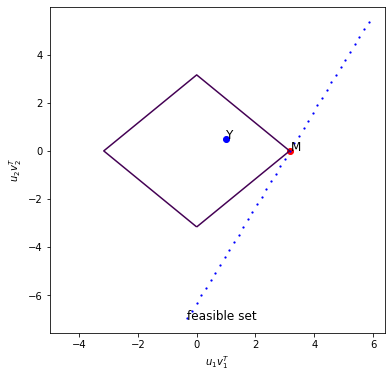

In [18]:
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.abs(X) + np.abs(Y)
fig, ax = plt.subplots(figsize=(6, 6))
ax.contour(X, Y, Z, levels=[M_norm])
plt.scatter(*s, c='r')
plt.text(*(1.01 * s), "M", fontsize=12)
for i in np.arange(-10, 10, 0.5):
    A = M.copy()
    A[0, 1] = i
    coeffs = get_coefficients(A)
    if i == -10:
        plt.text(*(np.array(coeffs) * 1.01), "feasible set", fontsize=12)
    plt.scatter(*get_coefficients(A), c='b', s=1.5)

plt.scatter(1, get_dual(base), c='b')
plt.text((1 + 0.01), get_dual(base) * (1.01), "Y", fontsize=12)
print(f"Dual Y:\n {base[0] + get_dual(base) * base[1]}")
plt.xlabel(r'$u_1v_1^T$')
plt.ylabel(r'$u_2v_2^T$')
plt.show()

/tmp/ipykernel_1066178/1976563210.py:12: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(X, Y, Z, 20, lw=1, linestyles="solid")


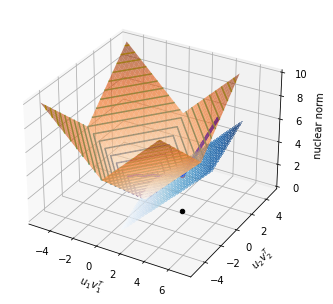

In [22]:
z = get_coefficients(M)

X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = np.abs(X) + np.abs(Y)

fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=.6, cmap=cm.Oranges)
ax.contour(X, Y, Z, 20, lw=1, linestyles="solid")
subgradient = base[0] + get_dual(base) * base[1]
X = np.arange(s[0] - 4, s[0] + 4, 0.25)
Y = np.arange(s[1] - 2, s[1] + 2, 0.25)
X, Y = np.meshgrid(X, Y)
Z = M_norm + (X - s[0]) + get_dual(base) * (Y - s[1])
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, lw=0.5, cmap=cm.Blues, alpha=.4, antialiased=False)
#ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5)

M3d = s[0], s[1], np.abs(s[0]) + np.abs(s[1])
ax.scatter(*M3d, c='r')
ax.scatter(*s, 0, c='black')

for i in np.arange(-5, 5, 0.01):
    A = M.copy()
    A[0, 1] = i
    x, y = get_coefficients(A)
    cords = x, y, np.abs(x) + np.abs(y)
    ax.scatter(*cords, c='b', s=1.5)
    # ax.scatter(x, y, 0, c='b', s=1.5)

# ax.view_init(10,50)
ax.set_zlim(0, 10)
ax.set_xlabel(r'$u_1v_1^T$')
ax.set_ylabel(r'$u_2v_2^T$')
ax.set_zlabel('nuclear norm')
plt.show()



In [ ]:
solver = NuclearNormMinimization()
X_input = M.copy()
X_input[0, 1] = np.nan
X_output = solver.fit_transform(X_input)
print(X_output)